In [1]:
%pip install pennylane torch torchvision torchaudio scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import shutil
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, datasets, models
from PIL import Image

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.qnn import TorchLayer

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"
N_PER_CLASS = 2500
TOTAL_SAMPLES = N_PER_CLASS * 2
IMG_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 40
LR = 1e-3

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Device: cpu


In [4]:
import os
from pathlib import Path
from shutil import copy2
from glob import glob
import random

SEED = 42
random.seed(SEED)
N_PER_CLASS = 2500
DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"

classes = ["Parasitized", "Uninfected"]
assert all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in classes), \
    f"Check DATA_DIR and folder names. Expected subfolders: {classes}"

SUBSET_DIR = os.path.join(DATA_DIR, "Malaria_Subset_5000")

# Check if subset exists
if os.path.exists(SUBSET_DIR):
    print("Subset dir exists — reusing existing files.")
else:
    os.makedirs(SUBSET_DIR)
    print("Subset dir created. Copying images...")

    for c in classes:
        src_dir = os.path.join(DATA_DIR, c)
        dst_dir = os.path.join(SUBSET_DIR, c)
        os.makedirs(dst_dir, exist_ok=True)

        all_imgs = sorted(glob(os.path.join(src_dir, "*")))
        random.Random(SEED).shuffle(all_imgs)

        count = 0
        for p in all_imgs:
            fname = os.path.basename(p)
            if fname.startswith(".") or fname.endswith(".db"):
                continue
            copy2(p, dst_dir)
            count += 1
            if count >= N_PER_CLASS:
                break

print("Subset ready at:", SUBSET_DIR)
print("Counts per class:")
for c in classes:
    dst_dir = os.path.join(SUBSET_DIR, c)
    print(f"{c}: {len(glob(os.path.join(dst_dir, '*')))} images")

Subset dir exists — reusing existing files.
Subset ready at: /content/drive/MyDrive/cell_images/cell_images/Malaria_Subset_5000
Counts per class:
Parasitized: 2500 images
Uninfected: 2500 images


In [5]:
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=None)
class_to_idx = full_dataset.class_to_idx
print("Class mapping:", class_to_idx)

# Split indices per class
indices_per_class = {cls_idx: [] for cls_idx in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(full_dataset.samples):
    indices_per_class[label].append(idx)

train_idx, val_idx, test_idx = [], [], []
for cls_idx, indices in indices_per_class.items():
    rng = random.Random(SEED)
    idxs = indices.copy()
    rng.shuffle(idxs)
    ncls_train = int(N_PER_CLASS * 0.70)
    ncls_val = int(N_PER_CLASS * 0.15)
    ncls_test = N_PER_CLASS - ncls_train - ncls_val
    train_idx.extend(idxs[:ncls_train])
    val_idx.extend(idxs[ncls_train:ncls_train + ncls_val])
    test_idx.extend(idxs[ncls_train + ncls_val: ncls_train + ncls_val + ncls_test])

# Create datasets and subsets
train_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)

print("Split sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Class mapping: {'Parasitized': 0, 'Uninfected': 1}
Split sizes: 3500 750 750


In [6]:
class SimpleCNNBackbone(nn.Module):
    def __init__(self, out_features=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, out_features, kernel_size=3, padding=1),  # output 4 channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        return x  # 4 features

In [7]:
class ClassicalModel(nn.Module):
    def __init__(self, n_features=4, n_classes=NUM_CLASSES):
        super().__init__()
        self.backbone = SimpleCNNBackbone(out_features=n_features)
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features)
        return out

model = ClassicalModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

ClassicalModel(
  (backbone): SimpleCNNBackbone(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

In [15]:
from tqdm import trange, tqdm
import time

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0
best_state = None

total_start = time.time()  # total training time start

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Progress bar for batches inside this epoch
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    epoch_train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in batch_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        batch_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{correct/total*100:.2f}%"})

    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_acc = correct / total

    # Validation (no progress bar needed)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Val Acc: {val_acc*100:.2f}% | "
          f"Epoch Time: {epoch_time:.2f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model with Val Acc: {best_val_acc*100:.2f}%")

total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f} seconds")

Epoch 1/40 | Train Acc: 49.31% | Val Acc: 56.13% | Epoch Time: 367.59s


Epoch 2/40 | Train Acc: 54.40% | Val Acc: 61.47% | Epoch Time: 31.16s


Epoch 3/40 | Train Acc: 61.69% | Val Acc: 67.47% | Epoch Time: 31.50s


Epoch 4/40 | Train Acc: 66.91% | Val Acc: 75.20% | Epoch Time: 32.33s


Epoch 5/40 | Train Acc: 67.71% | Val Acc: 72.40% | Epoch Time: 31.58s


Epoch 6/40 | Train Acc: 72.71% | Val Acc: 60.13% | Epoch Time: 31.49s


Epoch 7/40 | Train Acc: 77.29% | Val Acc: 84.80% | Epoch Time: 31.83s


Epoch 8/40 | Train Acc: 80.69% | Val Acc: 80.40% | Epoch Time: 31.83s


Epoch 9/40 | Train Acc: 85.06% | Val Acc: 90.27% | Epoch Time: 31.56s


Epoch 10/40 | Train Acc: 86.83% | Val Acc: 87.87% | Epoch Time: 32.81s


Epoch 11/40 | Train Acc: 87.94% | Val Acc: 92.00% | Epoch Time: 33.30s


Epoch 12/40 | Train Acc: 88.91% | Val Acc: 90.67% | Epoch Time: 33.68s


Epoch 13/40 | Train Acc: 89.37% | Val Acc: 91.87% | Epoch Time: 32.29s


Epoch 14/40 | Train Acc: 89.91% | Val Acc: 91.20% | Epoch Time: 32.50s


Epoch 15/40 | Train Acc: 90.66% | Val Acc: 91.33% | Epoch Time: 32.78s


Epoch 16/40 | Train Acc: 90.69% | Val Acc: 91.73% | Epoch Time: 32.42s


Epoch 17/40 | Train Acc: 90.31% | Val Acc: 93.47% | Epoch Time: 32.41s


Epoch 18/40 | Train Acc: 90.40% | Val Acc: 92.40% | Epoch Time: 31.87s


Epoch 19/40 | Train Acc: 91.09% | Val Acc: 92.13% | Epoch Time: 31.76s


Epoch 20/40 | Train Acc: 90.14% | Val Acc: 92.13% | Epoch Time: 32.16s


Epoch 21/40 | Train Acc: 90.63% | Val Acc: 92.27% | Epoch Time: 31.78s


Epoch 22/40 | Train Acc: 90.29% | Val Acc: 92.13% | Epoch Time: 31.67s


Epoch 23/40 | Train Acc: 90.89% | Val Acc: 92.13% | Epoch Time: 31.12s


Epoch 24/40 | Train Acc: 91.49% | Val Acc: 93.47% | Epoch Time: 30.95s


Epoch 25/40 | Train Acc: 91.14% | Val Acc: 93.07% | Epoch Time: 31.50s


Epoch 26/40 | Train Acc: 91.91% | Val Acc: 92.93% | Epoch Time: 32.31s


Epoch 27/40 | Train Acc: 91.37% | Val Acc: 93.20% | Epoch Time: 32.83s


Epoch 28/40 | Train Acc: 91.60% | Val Acc: 93.60% | Epoch Time: 30.58s


Epoch 29/40 | Train Acc: 91.63% | Val Acc: 93.47% | Epoch Time: 31.32s


Epoch 30/40 | Train Acc: 91.86% | Val Acc: 93.33% | Epoch Time: 31.72s


Epoch 31/40 | Train Acc: 91.43% | Val Acc: 93.60% | Epoch Time: 32.60s


Epoch 32/40 | Train Acc: 91.89% | Val Acc: 93.60% | Epoch Time: 33.46s


Epoch 33/40 | Train Acc: 90.51% | Val Acc: 92.00% | Epoch Time: 33.21s


Epoch 34/40 | Train Acc: 91.46% | Val Acc: 92.40% | Epoch Time: 35.21s


Epoch 35/40 | Train Acc: 91.40% | Val Acc: 92.67% | Epoch Time: 36.81s


Epoch 36/40 | Train Acc: 91.09% | Val Acc: 91.87% | Epoch Time: 73.86s


Epoch 37/40 | Train Acc: 91.77% | Val Acc: 93.20% | Epoch Time: 56.22s


Epoch 38/40 | Train Acc: 91.86% | Val Acc: 93.20% | Epoch Time: 40.82s


Epoch 39/40 | Train Acc: 91.63% | Val Acc: 93.73% | Epoch Time: 34.24s


Epoch 40/40 | Train Acc: 91.83% | Val Acc: 93.47% | Epoch Time: 32.00s

Loaded best model with Val Acc: 93.73%
Total Training Time: 1703.07 seconds


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Total Test Time: 12.6719 sec
Avg Inference Time: 0.016896 sec/image (59.19 FPS)
Accuracy: 92.93%  Precision: 0.9375  Recall: 0.9200  F1: 0.9287

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       375
           1       0.92      0.94      0.93       375

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



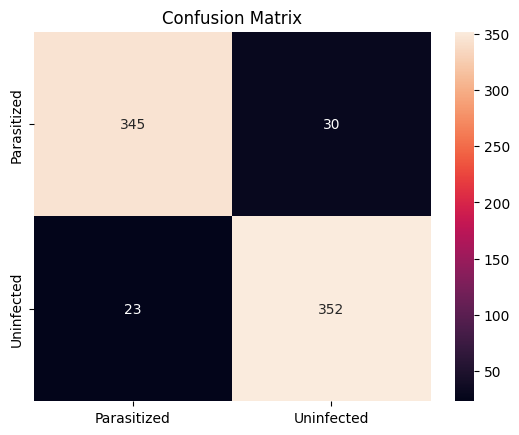

In [20]:
import seaborn as sns
all_preds, all_labels = [], []
model.eval()

start_time = time.time()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

total_test_time = time.time() - start_time
avg_time = total_test_time / len(test_loader.dataset)

print(f"Total Test Time: {total_test_time:.4f} sec")
print(f"Avg Inference Time: {avg_time:.6f} sec/image ({1/avg_time:.2f} FPS)")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', pos_label=class_to_idx['Parasitized'])
print(f"Accuracy: {acc*100:.2f}%  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=list(class_to_idx.keys()), yticklabels=list(class_to_idx.keys()))
plt.title("Confusion Matrix")
plt.show()

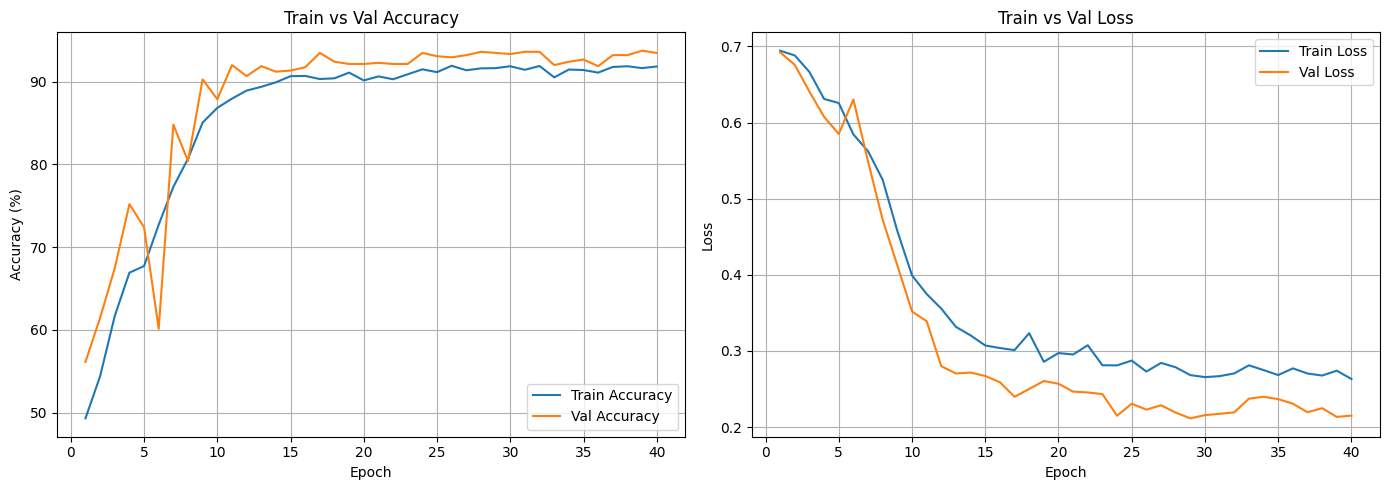

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Accuracy
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in train_accs], label="Train Accuracy")
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in val_accs], label="Val Accuracy")
axs[0].set_title("Train vs Val Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

# Loss
axs[1].plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
axs[1].plot(range(1, NUM_EPOCHS+1), val_losses, label="Val Loss")
axs[1].set_title("Train vs Val Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()